MediaGamma - Take Home Test
======

Qikai Gu

July 17, 2018


The test is about building a CTR prediction model with one of provided datasets. 
I picked [https://www.kaggle.com/c/avazu-ctr-prediction](https://www.kaggle.com/c/avazu-ctr-prediction).

It's expected to:
- finish the test in 2-3 hours
- return the results in 2 weeks but the sooner the better
- build an end-to-end pipeline for the task
- showcase my understanding of various aspects of ML: ETL, model building and selection, evaluation, etc.
- develop in python (jupyter notebooks) with reasonable comments
- use version control with appropriate commit messages

In [1]:
import numpy as np
import pandas as pd
import xlearn as xl
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy.special import logit, expit
import matplotlib.pyplot as plt

%matplotlib inline

### Loading data

In [10]:
# Use only 'train.gz' here as we need labeled data to evaluate our models.
df = pd.read_csv('input/train.gz', # nrows=100000,
                 compression='gzip', dtype={'id': str}, index_col='id')

In [3]:
pd.set_option('display.max_columns', 100)
df.head()

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
id,,,,,,,,,,,,,,,,,,,,,,,
1000009418151094273,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,ddd2926e,44956a24,1,2,15706,320,50,1722,0,35,-1,79
10000169349117863715,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,96809ac8,711ee120,1,0,15704,320,50,1722,0,35,100084,79
10000371904215119486,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,b3cf8def,8a4875bd,1,0,15704,320,50,1722,0,35,100084,79
10000640724480838376,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e8275b8f,6332421a,1,0,15706,320,50,1722,0,35,100084,79
10000679056417042096,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,07d7df22,a99f214a,9644d0bf,779d90c2,1,0,18993,320,50,2161,0,35,-1,157


In [4]:
print('dataset shape: \t{}'.format(df.shape))

dataset shape: 	(40428967, 23)


### Feature engineering

Check class balance, it seems the class imbalance is not so bad.

In [5]:
df.click.value_counts()

0    33563901
1     6865066
Name: click, dtype: int64

Show features and types

In [6]:
pd.set_option('display.max_rows', 30)
df.dtypes

click                int64
hour                 int64
C1                   int64
banner_pos           int64
site_id             object
site_domain         object
site_category       object
app_id              object
app_domain          object
app_category        object
device_id           object
device_ip           object
device_model        object
device_type          int64
device_conn_type     int64
C14                  int64
C15                  int64
C16                  int64
C17                  int64
C18                  int64
C19                  int64
C20                  int64
C21                  int64
dtype: object

Check if there's any NaN values

In [7]:
for col in df.columns:
    print('{:20}: {}'.format(col, df[col].hasnans))

click               : False
hour                : False
C1                  : False
banner_pos          : False
site_id             : False
site_domain         : False
site_category       : False
app_id              : False
app_domain          : False
app_category        : False
device_id           : False
device_ip           : False
device_model        : False
device_type         : False
device_conn_type    : False
C14                 : False
C15                 : False
C16                 : False
C17                 : False
C18                 : False
C19                 : False
C20                 : False
C21                 : False


Plot the top value counts of the features

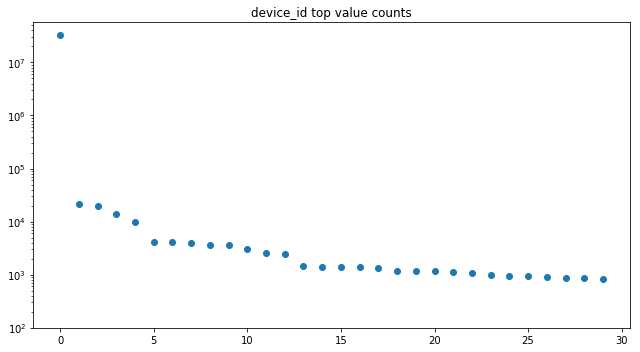

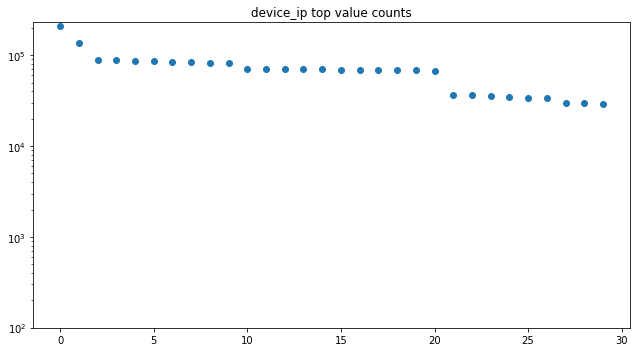

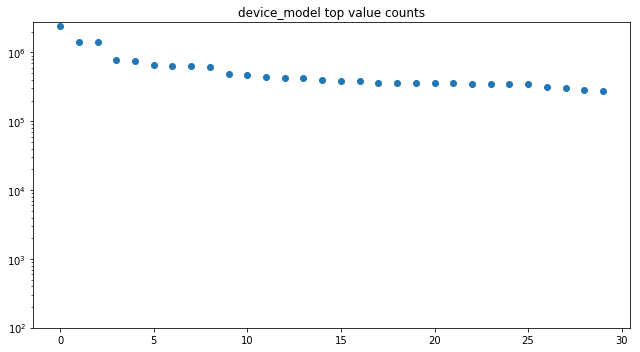

In [8]:
def plot_value_counts(series, title='', size=30):
    cnts = series.values[:size]
    x = range(len(cnts))
    plt.plot(x, cnts, 'o')
    plt.yscale('log')
    plt.ylim(1e2)
    plt.title(title)
    plt.tight_layout()
    plt.show()

plt.rcParams['figure.figsize'] = (9.0, 5.0)
for col in ['device_id', 'device_ip', 'device_model']:
    plot_value_counts(df[col].value_counts(), title='{} top value counts'.format(col))

For those device features having obvious difference in value count distribution, add a new feature showing if the value appeared frequently or not. They may be useful features.

In [11]:
counts_thresholds = {
    'device_id': 1e7,
    'device_ip': 1e5,
    'device_model': 1e6
}
for col, threshold in counts_thresholds.items():
    counts = df[col].value_counts().to_dict()
    df[col + '_large'] = df[col].apply(lambda x: counts[x] >= threshold)

In [ ]:
fields = df.columns[1:]

Print some more information about device.

In [14]:
for col in ['device_type', 'device_conn_type']:
    print(df[col].value_counts())

1    37304667
0     2220812
4      774272
5      129185
2          31
Name: device_type, dtype: int64
0    34886838
2     3317443
3     2181796
5       42890
Name: device_conn_type, dtype: int64


It looks good, there aren't too many levels.

In [15]:
pd.set_option('display.max_rows', 15)

# Print value counts about site
for col in ['site_id', 'site_domain', 'site_category']:
    print(df[col].value_counts()[:10])

85f751fd    14596137
1fbe01fe     6486150
e151e245     2637747
d9750ee7      963745
5b08c53b      913325
5b4d2eda      771360
856e6d3f      765891
a7853007      461311
b7e9786d      369099
5ee41ff2      349008
Name: site_id, dtype: int64
c4e18dd6    15131739
f3845767     6486150
7e091613     3325008
7687a86e     1290165
98572c79      996816
16a36ef3      855686
58a89a43      765891
9d54950b      375891
b12b9f85      373925
17d996e6      353600
Name: site_domain, dtype: int64
50e219e0    16537234
f028772b    12657073
28905ebd     7377208
3e814130     3050306
f66779e6      252451
75fa27f6      160985
335d28a8      136463
76b2941d      104754
c0dd3be3       42090
72722551       28216
Name: site_category, dtype: int64


In [16]:
# Print value counts about app
for col in ['app_id', 'app_domain', 'app_category']:
    print(df[col].value_counts()[:10])

ecad2386    25832830
92f5800b     1555283
e2fcccd2     1129016
febd1138      759098
9c13b419      757812
7358e05e      615635
a5184c22      491457
d36838b1      457572
685d1c4c      408515
54c5d545      397693
Name: app_id, dtype: int64
7801e8d9    27237087
2347f47a     5240885
ae637522     1881838
5c5a694b     1129228
82e27996      759125
d9b5648e      713924
0e8616ad      660510
b9528b13      646193
b8d325c3      534000
aefc06bd      298769
Name: app_domain, dtype: int64
07d7df22    26165592
0f2161f8     9561058
cef3e649     1731545
8ded1f7a     1467257
f95efa07     1141673
d1327cf5      123233
09481d60       54886
dc97ec06       54644
75d80bbe       40108
fc6fa53d       23663
Name: app_category, dtype: int64


There are many levels in site and app features. In order to reduce processing time and scale the model, I will train multiple models with subsets having same site_id or app_id.

### Train test split

Test set is randomly selected. I use a dictionary to store sub training sets. To time reason, I only put 6 subsets, but we can add more subsets if needed.

In [13]:
test_size = 200000
test_ids = np.random.choice(df.index, test_size, replace=False)
test_df = df.loc[test_ids]

sub_dfs = {
    'site_id': [
        '85f751fd',
        '1fbe01fe',
        'e151e245'
    ],
    'app_id': [
        'ecad2386',
        '92f5800b',
        'e2fcccd2'
    ]
}

def data_slice(df):
    dfs = {}
    for field in sub_dfs:
        for feature in sub_dfs[field]:
            key = '{}:{}'.format(field, feature)
            dfs[key] = df.loc[df[field] == feature].sample(frac=0.1, random_state=42)
    return dfs

train_dfs = data_slice(df.loc[~df.index.isin(test_ids)])

del df

### Data formatting

As I'm going to use FFM models, this section converts datasets into suitable format.

In [14]:
# Define a class to structure field and feature mappings

class FFMap(dict):
    """A fields and features map structured as:
    {
        'fields': {
            field1: {
                'idx': field1_idx,
                'features': {
                    feature1: feature1_idx,
                    ...
                }
                'feature_cnt': 1
            },
            ...
        },
        'field_cnt': 0
    }
    """
    def __init__(self):
        super(FFMap, self).__init__(
            {'fields': {}, 
             'field_cnt': 0})
    
    def _has_field(self, field):
        return field in self['fields']
    
    def _has_feature(self, field, feature):
        return self._has_field and \
               feature in self['fields'][field]['features']
    
    def _add_feature(self, field, feature):
        self['fields'][field]['features'][feature] = \
            self['fields'][field]['feature_cnt']
        self['fields'][field]['feature_cnt'] += 1
    
    def _get_field_idx(self, field):
        return self['fields'][field]['idx']
    
    def _get_feature_idx(self, field, feature):
        return self['fields'][field]['features'][feature]
    
    def _get_value(self, field, feature):
        return '{}:{}:1'.format(self._get_field_idx(field), 
                                self._get_feature_idx(field, feature))
        
    def update_field(self, field):
        if self._has_field(field):
            return

        self['fields'][field] = {
            'idx': self['field_cnt'],
            'features': {},
            'feature_cnt': 0
        }
        self['field_cnt'] += 1
        
    def convert_feature(self, field, feature):
        if not self._has_feature(field, feature):
            self._add_feature(field, feature)
        return self._get_value(field, feature)

In [15]:
def convert_feature(ffmap, field, feature):
    return ffmap.convert_feature(field, feature)

def df_to_ffm(df, ffmap, fields, name, label_col=None):
    ffm = pd.DataFrame()
    if label_col:
        ffm[label_col] = df[label_col]
    
    for field in fields:
        ffmap.update_field(field)
        ffm[field] = df[field].apply(
            lambda feature: convert_feature(ffmap, field, feature))
    
    ffm.to_csv('{}.ffm'.format(name), sep=' ', header=False, index=False)

In [17]:
%%time

# Create datasets
ffmap = FFMap()
df_to_ffm(test_df, ffmap, fields, name='test')

for key, sub_df in train_dfs.items():
    size = sub_df.shape[0]
    train_size = int(size * 0.9)
    df_to_ffm(sub_df[:train_size], ffmap, fields, 'train_' + key, label_col='click')
    df_to_ffm(sub_df[train_size:], ffmap, fields, 'valid_' + key, label_col='click')

CPU times: user 3min 36s, sys: 2.26 s, total: 3min 39s
Wall time: 3min 39s


### Building and training models

For each subset, train an individual model and combine the prediction of all models at the end.

Because all the features are categorical data, the entire dataset is very sparse. FFM performs better on sparse data and requires less space compare to linear models or tree based models.

In [18]:
%%time

# Train & predict all sub datasets
for key, sub_df in train_dfs.items():
    ffm_model = xl.create_ffm()
    ffm_model.setTrain('train_{}.ffm'.format(key))
    ffm_model.setValidate('valid_{}.ffm'.format(key))

    params = {'task': 'binary', 
              'k': 2,
              'lr': 0.1,
              'lambda': 1e-3,
              'metric': 'auc',
              'epoch': 1000  # auto early stop
             }

    ffm_model.fit(params, 'model_{}.out'.format(key))
    
    ffm_model.setTest('test.ffm')
    ffm_model.setSigmoid()
    ffm_model.predict('model_{}.out'.format(key), 'output_{}.txt'.format(key))

CPU times: user 4h 31min 24s, sys: 6 s, total: 4h 31min 30s
Wall time: 24min 50s


Combien results

In [82]:
def combine(arr):
    return expit(logit(arr).mean())

pred_matrix = []
for key in train_dfs:
    with open('output_{}.txt'.format(key), 'r') as f:
        pred = np.array([float(p) for p in f.readlines()])
    pred_matrix.append(pred)

pred_matrix = np.array(pred_matrix)

y_pred = np.apply_along_axis(combine, 0, pred_matrix)

### Evaluation

I use AUC as evaluation metric. This metric evaluates the ranking ability of the CTR, which can reduce the impact of bias.

In [86]:
y_true = test_df['click'].values

fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
roc_auc

0.6723097029883054

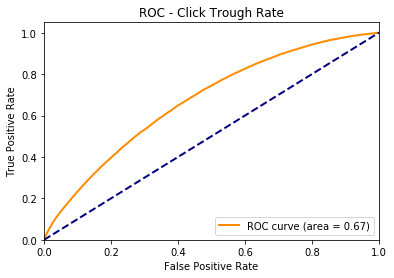

In [87]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Click Trough Rate')
plt.legend(loc="lower right")
plt.show()

As I only picked 6 subsets and 10% data of each set, the auc score is not very impressive. By increasing the training data size, it would have a better result.